In [1]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from torch.utils.data import Dataset, DataLoader
import glob
import json
from tqdm.notebook import tqdm
import torch.optim as optim
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Using backend: pytorch


## Homework 4 - Generative Models of graphs

first lets introduce our dataset, the "flower graphs" dataset


In [2]:
class CustomDataset(Dataset):
    def __init__(self, path):
        

        filelist = glob.glob(path+'/*.json')
        
        self.graphs = []
        for fname in tqdm(filelist):
            with open(fname) as jfile:
                graph = nx.node_link_graph(json.load(jfile))
                g = dgl.DGLGraph()
                g.from_networkx(graph)
                
                self.graphs.append(g)
        
        
    def __len__(self):
       
        return len(self.graphs)


    def __getitem__(self, idx):
        
    
        return self.graphs[idx]

In [3]:
graph_ds = CustomDataset('flower_graphs/')

Its a pretty simple dataset, just an "inner circle" plus some short arms,
no node features or edge features

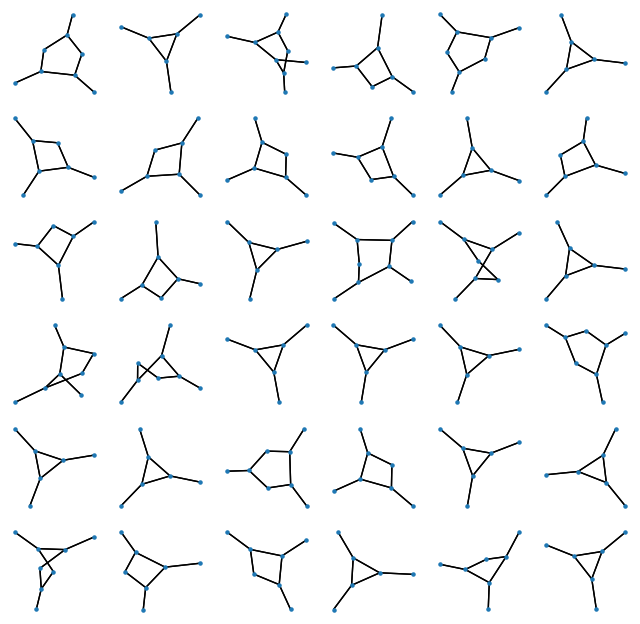

In [4]:
N = 6

fig,ax = plt.subplots(N,N,figsize=(8,8),dpi=100)


idxs = np.random.permutation(np.arange(len(graph_ds)))

for i in range(N):
    for j in range(N):
        idx = idxs[i*N+j]
        nx.draw( graph_ds[idx].to_networkx() ,ax=ax[i][j],node_size=5,arrows=False)

plt.show()

## your goal is to train a network that will generate graphs like these

based on what you saw in the lecture - you need to turn the graph into a sequence of "actions"

the tutorial we are following
https://docs.dgl.ai/en/0.4.x/tutorials/models/3_generative_model/5_dgmg.html

uses a sequence of integers, that represent different things based on where we are in the sequence

the function below converts a graph to a sequence in the right format

In [5]:
def get_decision_sequence(g):
    
    nodes = np.random.permutation( g.nodes() )
    
    edge_start, edge_end = g.edges()
    
    elist = np.random.permutation([(es,ee) for es,ee in zip(edge_start, edge_end)])
    
    added_nodes = []
    added_edges = []
    
    decision_sequence = []

    for node_idx in nodes:
        decision_sequence.append(0)  # Add node
        
        added_nodes.append(node_idx)
        
        edges_from_node = [e for e in elist if e[0]==node_idx]
        
        for e in edges_from_node:
            
            if e[1] not in added_nodes:
                continue
            elif (e[1],e[0]) in added_edges:
                continue
            decision_sequence.append(0)  # Add edge
            dst = np.where(added_nodes==e[1])[0][0]
            decision_sequence.append(dst)  # Set destination to be previous node.
            added_edges.append((e[0],e[1]))
            
        decision_sequence.append(1)  # Stop adding edge
    decision_sequence.append(1)  # Stop adding node

    return decision_sequence


In [6]:
get_decision_sequence( graph_ds[5] )

[0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 3,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 4,
 0,
 3,
 0,
 0,
 1,
 1]

## after you copy-paste all the following code:

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Bernoulli
from torch.distributions import Categorical
from functools import partial

class DGMGSkeleton(nn.Module):
    def __init__(self, v_max):
        """
        Parameters
        ----------
        v_max: int
            Max number of nodes considered
        """
        super(DGMGSkeleton, self).__init__()

        # Graph configuration
        self.v_max = v_max

    def add_node_and_update(self, a=None):
        """Decide if to add a new node.
        If a new node should be added, update the graph."""
        return NotImplementedError

    def add_edge_or_not(self, a=None):
        """Decide if a new edge should be added."""
        return NotImplementedError

    def choose_dest_and_update(self, a=None):
        """Choose destination and connect it to the latest node.
        Add edges for both directions and update the graph."""
        return NotImplementedError

    def forward_train(self, actions):
        """Forward at training time. It records the probability
        of generating a ground truth graph following the actions."""
        return NotImplementedError

    def forward_inference(self):
        """Forward at inference time.
        It generates graphs on the fly."""
        return NotImplementedError

    def forward(self, actions=None):
        # The graph you will work on
        self.g = dgl.DGLGraph()

        # If there are some features for nodes and edges,
        # zero tensors will be set for those of new nodes and edges.
        self.g.set_n_initializer(dgl.frame.zero_initializer)
        self.g.set_e_initializer(dgl.frame.zero_initializer)

        if self.training:
            return self.forward_train(actions=actions)
        else:
            return self.forward_inference()
    
def forward_inference(self):
    stop = self.add_node_and_update()
    while (not stop) and (self.g.number_of_nodes() < self.v_max + 1):
        num_trials = 0
        to_add_edge = self.add_edge_or_not()
        while to_add_edge and (num_trials < self.g.number_of_nodes() - 1):
            self.choose_dest_and_update()
            num_trials += 1
            to_add_edge = self.add_edge_or_not()
        stop = self.add_node_and_update()

    return self.g
    
def forward_train(self, actions):
    """
    - actions: list
        - Contains a_1, ..., a_T described above
    - self.prepare_for_train()
        - Initializes self.action_step to be 0, which will get
          incremented by 1 every time it is called.
        - Initializes objects recording log p(a_t|a_1,...a_{t-1})

    Returns
    -------
    - self.get_log_prob(): log p(a_1, ..., a_T)
    """
    self.prepare_for_train()

    stop = self.add_node_and_update(a=actions[self.action_step])
    while not stop:
        to_add_edge = self.add_edge_or_not(a=actions[self.action_step])
        while to_add_edge:
            self.choose_dest_and_update(a=actions[self.action_step])
            to_add_edge = self.add_edge_or_not(a=actions[self.action_step])
        stop = self.add_node_and_update(a=actions[self.action_step])

    return self.get_log_prob()
    
class GraphEmbed(nn.Module):
    def __init__(self, node_hidden_size):
        super(GraphEmbed, self).__init__()

        # Setting from the paper
        self.graph_hidden_size = 2 * node_hidden_size

        # Embed graphs
        self.node_gating = nn.Sequential(
            nn.Linear(node_hidden_size, 1),
            nn.Sigmoid()
        )
        self.node_to_graph = nn.Linear(node_hidden_size,
                                       self.graph_hidden_size)

    def forward(self, g):
        if g.number_of_nodes() == 0:
            return torch.zeros(1, self.graph_hidden_size)
        else:
            # Node features are stored as hv in ndata.
            hvs = g.ndata['hv']
            return (self.node_gating(hvs) *
                    self.node_to_graph(hvs)).sum(0, keepdim=True)
    
class GraphProp(nn.Module):
    def __init__(self, num_prop_rounds, node_hidden_size):
        super(GraphProp, self).__init__()

        self.num_prop_rounds = num_prop_rounds

        # Setting from the paper
        self.node_activation_hidden_size = 2 * node_hidden_size

        message_funcs = []
        node_update_funcs = []
        self.reduce_funcs = []

        for t in range(num_prop_rounds):
            # input being [hv, hu, xuv]
            message_funcs.append(nn.Linear(2 * node_hidden_size + 1,
                                           self.node_activation_hidden_size))

            self.reduce_funcs.append(partial(self.dgmg_reduce, round=t))
            node_update_funcs.append(
                nn.GRUCell(self.node_activation_hidden_size,
                           node_hidden_size))

        self.message_funcs = nn.ModuleList(message_funcs)
        self.node_update_funcs = nn.ModuleList(node_update_funcs)

    def dgmg_msg(self, edges):
        """For an edge u->v, return concat([h_u, x_uv])"""
        return {'m': torch.cat([edges.src['hv'],
                                edges.data['he']],
                               dim=1)}

    def dgmg_reduce(self, nodes, round):
        hv_old = nodes.data['hv']
        m = nodes.mailbox['m']
        message = torch.cat([
            hv_old.unsqueeze(1).expand(-1, m.size(1), -1), m], dim=2)
        node_activation = (self.message_funcs[round](message)).sum(1)

        return {'a': node_activation}

    def forward(self, g):
        if g.number_of_edges() > 0:
            for t in range(self.num_prop_rounds):
                g.update_all(message_func=self.dgmg_msg,
                             reduce_func=self.reduce_funcs[t])
                g.ndata['hv'] = self.node_update_funcs[t](
                     g.ndata['a'], g.ndata['hv'])
    

def bernoulli_action_log_prob(logit, action):
    """Calculate the log p of an action with respect to a Bernoulli
    distribution. Use logit rather than prob for numerical stability."""
    if action == 0:
        return F.logsigmoid(-logit)
    else:
        return F.logsigmoid(logit)

class AddNode(nn.Module):
    def __init__(self, graph_embed_func, node_hidden_size):
        super(AddNode, self).__init__()

        self.graph_op = {'embed': graph_embed_func}

        self.stop = 1
        self.add_node = nn.Linear(graph_embed_func.graph_hidden_size, 1)

        # If to add a node, initialize its hv
        self.node_type_embed = nn.Embedding(1, node_hidden_size)
        self.initialize_hv = nn.Linear(node_hidden_size + \
                                       graph_embed_func.graph_hidden_size,
                                       node_hidden_size)

        self.init_node_activation = torch.zeros(1, 2 * node_hidden_size)

    def _initialize_node_repr(self, g, node_type, graph_embed):
        """Whenver a node is added, initialize its representation."""
        num_nodes = g.number_of_nodes()
        hv_init = self.initialize_hv(
            torch.cat([
                self.node_type_embed(torch.LongTensor([node_type])),
                graph_embed], dim=1))
        g.nodes[num_nodes - 1].data['hv'] = hv_init
        g.nodes[num_nodes - 1].data['a'] = self.init_node_activation

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, action=None):
        graph_embed = self.graph_op['embed'](g)

        logit = self.add_node(graph_embed)
        prob = torch.sigmoid(logit)

        if not self.training:
            action = Bernoulli(prob).sample().item()
        stop = bool(action == self.stop)

        if not stop:
            g.add_nodes(1)
            self._initialize_node_repr(g, action, graph_embed)

        if self.training:
            sample_log_prob = bernoulli_action_log_prob(logit, action)

            self.log_prob.append(sample_log_prob)

        return stop
    
class AddEdge(nn.Module):
    def __init__(self, graph_embed_func, node_hidden_size):
        super(AddEdge, self).__init__()

        self.graph_op = {'embed': graph_embed_func}
        self.add_edge = nn.Linear(graph_embed_func.graph_hidden_size + \
                                  node_hidden_size, 1)

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, action=None):
        graph_embed = self.graph_op['embed'](g)
        src_embed = g.nodes[g.number_of_nodes() - 1].data['hv']

        logit = self.add_edge(torch.cat(
            [graph_embed, src_embed], dim=1))
        prob = torch.sigmoid(logit)

        if self.training:
            sample_log_prob = bernoulli_action_log_prob(logit, action)
            self.log_prob.append(sample_log_prob)
        else:
            action = Bernoulli(prob).sample().item()

        to_add_edge = bool(action == 0)
        return to_add_edge

class ChooseDestAndUpdate(nn.Module):
    def __init__(self, graph_prop_func, node_hidden_size):
        super(ChooseDestAndUpdate, self).__init__()

        self.graph_op = {'prop': graph_prop_func}
        self.choose_dest = nn.Linear(2 * node_hidden_size, 1)

    def _initialize_edge_repr(self, g, src_list, dest_list):
        # For untyped edges, only add 1 to indicate its existence.
        # For multiple edge types, use a one-hot representation
        # or an embedding module.
        edge_repr = torch.ones(len(src_list), 1)
        g.edges[src_list, dest_list].data['he'] = edge_repr

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, dest):
        src = g.number_of_nodes() - 1
        possible_dests = range(src)

        src_embed_expand = g.nodes[src].data['hv'].expand(src, -1)
        possible_dests_embed = g.nodes[possible_dests].data['hv']

        dests_scores = self.choose_dest(
            torch.cat([possible_dests_embed,
                       src_embed_expand], dim=1)).view(1, -1)
        dests_probs = F.softmax(dests_scores, dim=1)

        if not self.training:
            dest = Categorical(dests_probs).sample().item()

        if not g.has_edge_between(src, dest):
            # For undirected graphs, add edges for both directions
            # so that you can perform graph propagation.
            src_list = [src, dest]
            dest_list = [dest, src]

            g.add_edges(src_list, dest_list)
            self._initialize_edge_repr(g, src_list, dest_list)

            self.graph_op['prop'](g)

        if self.training:
            if dests_probs.nelement() > 1:
                self.log_prob.append(
                    F.log_softmax(dests_scores, dim=1)[:, dest: dest + 1])

class DGMG(DGMGSkeleton):
    def __init__(self, v_max, node_hidden_size,
                 num_prop_rounds):
        super(DGMG, self).__init__(v_max)

        # Graph embedding module
        self.graph_embed = GraphEmbed(node_hidden_size)

        # Graph propagation module
        self.graph_prop = GraphProp(num_prop_rounds,
                                    node_hidden_size)

        # Actions
        self.add_node_agent = AddNode(
            self.graph_embed, node_hidden_size)
        self.add_edge_agent = AddEdge(
            self.graph_embed, node_hidden_size)
        self.choose_dest_agent = ChooseDestAndUpdate(
            self.graph_prop, node_hidden_size)

        # Forward functions
        self.forward_train = partial(forward_train, self=self)
        self.forward_inference = partial(forward_inference, self=self)

    @property
    def action_step(self):
        old_step_count = self.step_count
        self.step_count += 1

        return old_step_count

    def prepare_for_train(self):
        self.step_count = 0

        self.add_node_agent.prepare_training()
        self.add_edge_agent.prepare_training()
        self.choose_dest_agent.prepare_training()

    def add_node_and_update(self, a=None):
        """Decide if to add a new node.
        If a new node should be added, update the graph."""

        return self.add_node_agent(self.g, a)

    def add_edge_or_not(self, a=None):
        """Decide if a new edge should be added."""

        return self.add_edge_agent(self.g, a)

    def choose_dest_and_update(self, a=None):
        """Choose destination and connect it to the latest node.
        Add edges for both directions and update the graph."""

        self.choose_dest_agent(self.g, a)

    def get_log_prob(self):
        add_node_log_p = torch.cat(self.add_node_agent.log_prob).sum()
        add_edge_log_p = torch.cat(self.add_edge_agent.log_prob).sum()
        choose_dest_log_p = torch.cat(self.choose_dest_agent.log_prob).sum()
        return add_node_log_p + add_edge_log_p + choose_dest_log_p

model = DGMG(v_max=10, node_hidden_size=10, num_prop_rounds=5)

## depending on the model being in training or evaluation mode, it will either generate a model, or evaluate the likelihood given a sequence of steps

In [8]:
model.eval();

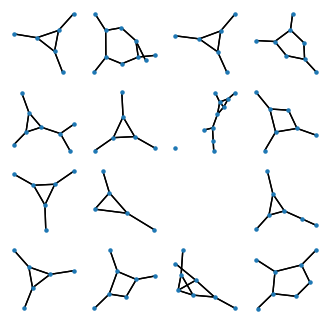

In [25]:
N = 4

fig,ax = plt.subplots(N,N,figsize=(4,4),dpi=100)




for i in range(N):
    for j in range(N):
        
        nx.draw( model().to_networkx() ,ax=ax[i][j],node_size=5,arrows=False)

plt.show()

In [10]:
# model.train();

In [11]:
# len(graph_ds)

In [12]:
# actions = get_decision_sequence(graph_ds[5])

In [13]:
# model(actions=actions).exp()

In [14]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [15]:
from tqdm.notebook import tqdm

n_epochs = 200

loss_vs_epoch = []
accuracy_vs_epoch = []

valid_loss_min = 20

for epoch in tqdm( range(n_epochs) ):
    # monitor losses
    train_loss = 0
    valid_loss = 0
    
    ###################
    # train the model #
    ###################

    model.train()
    #ind=1
    # training_accuracy=0
    # n_total=0

    for g in graph_ds:#data,label in training_dataloader:
        #print(ind)
        #ind+=1
#         if torch.cuda.is_available():
#             g = g.cuda(), label.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        actions = get_decision_sequence(g)
        output = model(actions=actions)

        #plt.imshow(data.cpu()[0][0],cmap='gist_yarg',vmin=0,vmax=1)
        #plt.imshow(output.cpu().detach().numpy()[0][0],cmap='gist_yarg',vmin=0,vmax=1)
        #stop


        
        #print(output,label)
        # calculate the loss
        loss = -output #loss_func(output,label.cuda())
        #print(loss)
        #stop
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.exp().item() #* data.size(0)
        
        
        #print(train_loss)
    #     output = output.cpu().data.numpy()
    #     prediction = np.argmax(output,axis=1)
    #     n_correct = len(np.where(label.cpu().numpy()==prediction)[0])
    #     n_total += len(label)
    #     training_accuracy += n_correct#/n_total

    # training_accuracy/=n_total
    #print(training_accuracy,n_total)


#     return n_correct/n_total, loss.item()                         
        
    
    ######################    
    # validate the model #
    ######################
    
#     model.eval()
#     # validation_accuracy=0
#     # n_total=0
    
    
#     for data,label in valid_dataloader:

#         if torch.cuda.is_available():
#             data, label = data.cuda(), label.cuda()
#         # forward pass: compute predicted outputs by passing inputs to the model
#         output = net(data.cuda())
#         # calculate the loss
#         loss = loss_func(output,label.cuda())
#         # update running validation loss 
#         valid_loss += loss.item() * data.size(0)

#         # output = output.cpu().data.numpy()
#         # prediction = np.argmax(output,axis=1)
#         # n_correct = len(np.where(label.cpu().numpy()==prediction)[0])
#         # n_total += len(label)
#         # validation_accuracy += n_correct#/n_total
    
#     # validation_accuracy/=n_total
#     #print(validation_accuracy,n_total)


    ######################    
    #     Statistics     #
    ######################
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = np.log10(train_loss / len(graph_ds))#training_dataloader.sampler)
    valid_loss = train_loss
#     valid_loss = valid_loss / len(valid_dataloader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'hw4_1.pt')
        valid_loss_min = valid_loss                         
        
        
    loss_vs_epoch.append([train_loss, valid_loss])

#     x, y = valid_ds[120]
#     fig,ax = plt.subplots(1,3,figsize=(6/2,(6/3)*2/2),dpi=250)
#     net.cpu()
#     net.eval()
#     input_img = x[0]
#     model_pred = net(x.unsqueeze(0))[0].cpu().data.numpy()[0]
#     ground_truth = y[0]
#     ax[0].set_title('Input',fontsize=8)
#     ax[1].set_title('Model Output',fontsize=8)
#     ax[2].set_title('Target',fontsize=8)
#     # ax[0].imshow(input_img*cats_std+cats_mean,cmap='gist_yarg',vmin=0,vmax=1)
#     # ax[1].imshow(model_pred*cats_std+cats_mean,cmap='gist_yarg',vmin=0,vmax=1)
#     # ax[2].imshow(ground_truth*cats_std+cats_mean,cmap='gist_yarg',vmin=0,vmax=1)
#     ax[0].imshow(input_img,cmap='gist_yarg',vmin=0,vmax=1)
#     ax[1].imshow(model_pred,cmap='gist_yarg',vmin=0,vmax=1)
#     ax[2].imshow(ground_truth,cmap='gist_yarg',vmin=0,vmax=1)
#     for i in range(3):
#       ax[i].set_axis_off()
#     plt.tight_layout()
#     plt.show()
#     net.cuda()
                         
                         
#     output = output.cpu().data.numpy()
#     prediction = np.argmax(output,axis=1)

#     n_correct = len(np.where(targets==prediction)[0])
#     n_total = len(targets)

#     return n_correct/n_total, loss.item()                         
    #print(training_accuracy,validation_accuracy)
    #accuracy_vs_epoch.append([training_accuracy, validation_accuracy])                     
    


Epoch: 1 	Training Loss: 14.864935 	Validation Loss: 14.864935
Validation loss decreased (20.000000 --> 14.864935).  Saving model ...
Epoch: 2 	Training Loss: 11.881703 	Validation Loss: 11.881703
Validation loss decreased (14.864935 --> 11.881703).  Saving model ...
Epoch: 3 	Training Loss: 11.260720 	Validation Loss: 11.260720
Validation loss decreased (11.881703 --> 11.260720).  Saving model ...
Epoch: 4 	Training Loss: 11.568836 	Validation Loss: 11.568836
Epoch: 5 	Training Loss: 12.746959 	Validation Loss: 12.746959
Epoch: 6 	Training Loss: 12.167192 	Validation Loss: 12.167192
Epoch: 7 	Training Loss: 11.126671 	Validation Loss: 11.126671
Validation loss decreased (11.260720 --> 11.126671).  Saving model ...
Epoch: 8 	Training Loss: 11.277932 	Validation Loss: 11.277932
Epoch: 9 	Training Loss: 11.472735 	Validation Loss: 11.472735
Epoch: 10 	Training Loss: 10.463992 	Validation Loss: 10.463992
Validation loss decreased (11.126671 --> 10.463992).  Saving model ...
Epoch: 11 	Tra

Epoch: 114 	Training Loss: 7.685147 	Validation Loss: 7.685147
Validation loss decreased (7.798123 --> 7.685147).  Saving model ...
Epoch: 115 	Training Loss: 8.363003 	Validation Loss: 8.363003
Epoch: 116 	Training Loss: 7.766055 	Validation Loss: 7.766055
Epoch: 117 	Training Loss: 8.160617 	Validation Loss: 8.160617
Epoch: 118 	Training Loss: 8.720003 	Validation Loss: 8.720003
Epoch: 119 	Training Loss: 8.049992 	Validation Loss: 8.049992
Epoch: 120 	Training Loss: 8.726829 	Validation Loss: 8.726829
Epoch: 121 	Training Loss: 8.208295 	Validation Loss: 8.208295
Epoch: 122 	Training Loss: 8.047681 	Validation Loss: 8.047681
Epoch: 123 	Training Loss: 8.553585 	Validation Loss: 8.553585
Epoch: 124 	Training Loss: 8.899253 	Validation Loss: 8.899253
Epoch: 125 	Training Loss: 8.187049 	Validation Loss: 8.187049
Epoch: 126 	Training Loss: 8.113690 	Validation Loss: 8.113690
Epoch: 127 	Training Loss: 8.067813 	Validation Loss: 8.067813
Epoch: 128 	Training Loss: 8.532252 	Validation L

In [21]:
#model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load('hw4_1.pt'))

<All keys matched successfully>

## submit the trained model source code + saved state_dict 

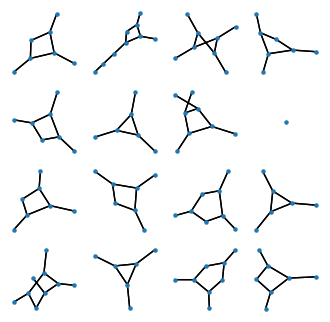

In [24]:
N = 4
model.eval()
fig,ax = plt.subplots(N,N,figsize=(4,4),dpi=100)


for i in range(N):
    for j in range(N):
        
        nx.draw( model().to_networkx() ,ax=ax[i][j],node_size=5,arrows=False)

plt.show()